In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import multi_gpu_model, to_categorical
from keras.layers import Conv2D, Input, Dense
from keras.models import Model

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle
import h5py

import sys, os, glob
sys.path.append("/home/bryanb/cuckoo-cli/")
import cuckoo_cl



In [65]:
# Design model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 1022, 32)      320       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 1022, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 1020, 32)      9248      
_________________________________________________________________
activation_8 (Activation)    (None, 28, 1020, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 510, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 508, 32)       9248      
_________________________________________________________________
activation_9 (Activation)    (None, 12, 508, 32)       0         
__________

In [66]:
dir_name = '/datax/scratch/bbrzycki/training/training2/'
h5_datasets = '/datax/scratch/bbrzycki/training/training2/data/1sig/1sig.hdf5'

model_fn = dir_name + 'models/1sig/simple_cnn.h5'
history_fn = dir_name + 'models/1sig/simple_cnn_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)

In [19]:
split_num = 4000
split = 'test'
total_image_num = split_num * 6
print(total_image_num)

ids = ['%06d' % i for i in range(total_image_num)]

# max_drift = 31.225e-6
dbs = []
ids = []
labels = {}
with h5py.File(h5_datasets, 'r') as f:
    
    # for 1 signal and 0 rfi
    for i in range(total_image_num):
        ID = '%06d' % i
        
        class_nums = f[split][ID].attrs['class_nums']
        sig_db = f[split][ID].attrs['sig_db']
        dbs.append(sig_db)
        
        ids.append(ID)

        start_index, end_index, line_width, snr, class_label = np.squeeze(f[split][ID]['signals_info'])
        # All between 0 and 1
        label = (start_index / 1024, end_index / 1024)
        labels[ID] = label

24000


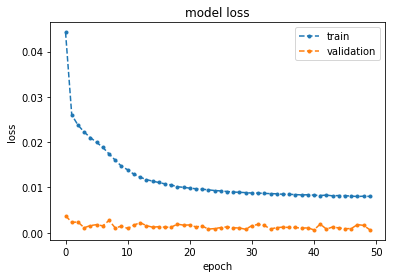

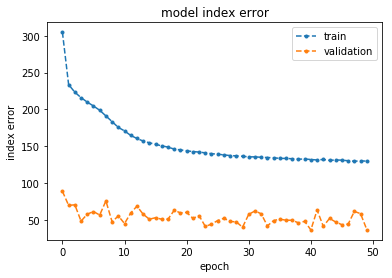

In [20]:
# "Loss"
plt.plot(history['loss'], '--.')
plt.plot(history['val_loss'], '--.')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(np.sqrt(np.array(history['loss'])*2)*1024, '--.')
plt.plot(np.sqrt(np.array(history['val_loss'])*2)*1024, '--.')
plt.title('model index error')
plt.ylabel('index error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Signal (db): 15
Label: (630.0, 580.0)
Prediction: (671.1, 572.9)
Sqrt of Error (index units): 41.74


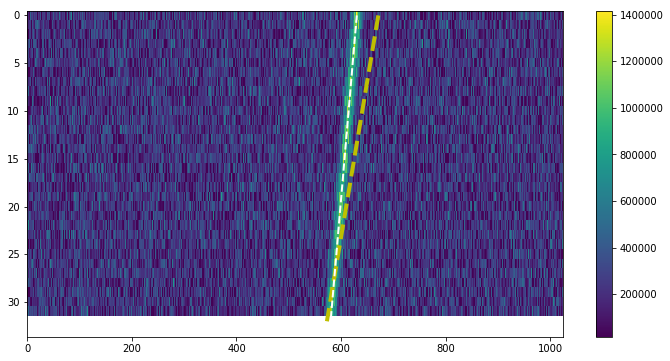

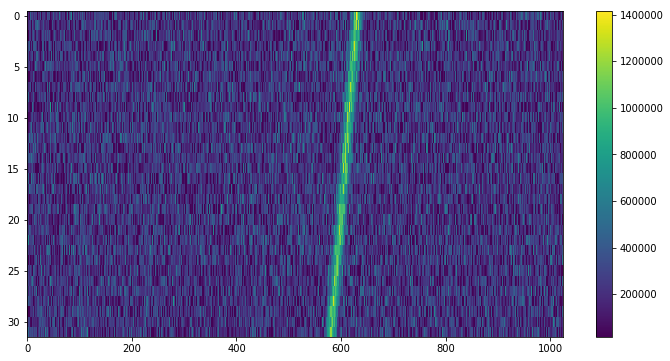

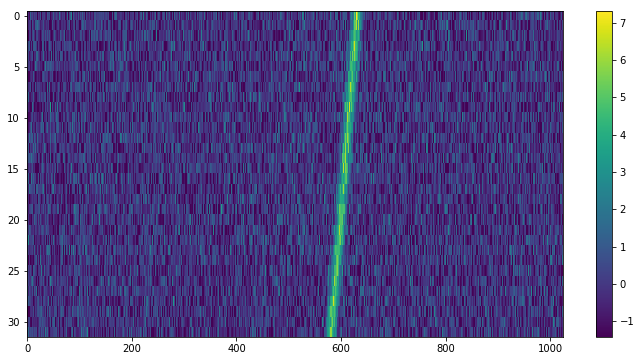

In [32]:
with h5py.File(h5_datasets, 'r') as f:
    split = 4000
    index = np.random.randint(0, split * 6)
    ID = '%06d' % index
        
    class_nums = f['test'][ID].attrs['class_nums']
    sig_db = f['test'][ID].attrs['sig_db']
    print('Signal (db):', sig_db)

    
    start_index, end_index, line_width, snr, class_label = np.squeeze(f['test'][ID]['signals_info'])
    # All between 0 and 1
    label = (start_index / 1024, end_index / 1024)
    print('Label:', (start_index, end_index))

    
filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
frame = np.load(filename)
X = np.copy(frame).reshape((1, 32, 1024, 1))
X -= np.mean(X)
X /= np.std(X)

p_start, p_end = model.predict(X)[0]
print('Prediction: (%0.1f, %0.1f)' % (p_start * 1024, p_end * 1024))

print('Sqrt of Error (index units): %0.2f' % (1024 * np.sqrt(np.mean((label[0] - p_start)**2 + (label[1] - p_end)**2))))

fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.plot([p_start * 1024, p_end * 1024], [0, 32], 'y', linestyle='--', lw=4)
plt.plot([label[0] * 1024, label[1] * 1024], [0, 32], 'w--', lw=2)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(12,6))
plt.imshow(X.reshape(32, 1024), aspect='auto')
plt.colorbar()
plt.show()



Try to evaluate this!

24000


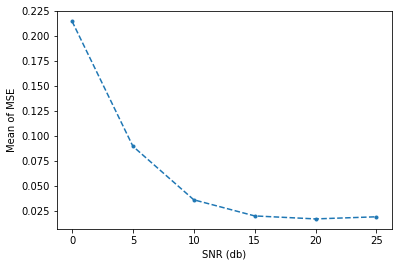

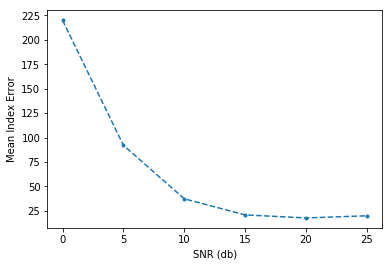

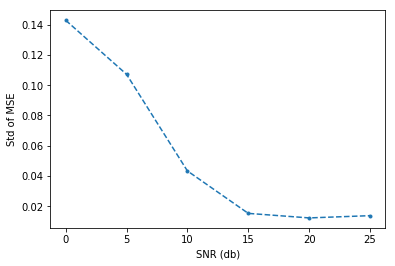

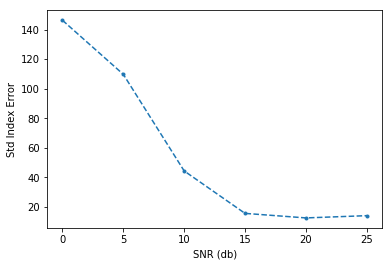

In [71]:
split_num = 4000
split = 'test'
total_image_num = split_num * 6
print(total_image_num)

ids = ['%06d' % i for i in range(total_image_num)]


db_num = 6
dbs = [i * 5 for i in range(db_num)]
db_errors = np.empty(db_num)

all_errors = np.empty(db_num * split_num)

with h5py.File(h5_datasets, 'r') as f:
    for i in range(db_num):
        sig_db = i * 5
        split_errors = np.empty(split_num)
        for j in range(split_num):
            ID_int = i * split_num + j
    
            ID = '%06d' % ID_int
        
            class_nums = f[split][ID].attrs['class_nums']
            this_db = f[split][ID].attrs['sig_db']
            assert sig_db == this_db

            start_index, end_index, line_width, snr, class_label = np.squeeze(f[split][ID]['signals_info'])
            # All between 0 and 1
            labels = np.array([start_index / 1024, end_index / 1024])
            
            filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
            frame = np.load(filename)
            X = np.copy(frame).reshape((1, 32, 1024, 1))
            X -= np.mean(X)
            X /= np.std(X)

            predictions = model.predict(X)[0]
            
            all_errors[ID_int] = split_errors[j] = np.mean(np.abs(predictions - labels))
        db_errors[i] = np.mean(split_errors)

db_errors = np.empty(db_num)
db_stds = np.empty(db_num)
for i in range(db_num):
    sig_db = i * 5
    db_data = all_errors[(split_num * i):(split_num * (i + 1))]
    db_errors[i] = np.mean(db_data)
    db_stds[i] = np.std(db_data)
            


plt.plot(dbs, db_errors, '--.')
plt.xlabel('SNR (db)')
plt.ylabel('Mean of MSE')
plt.show()

plt.plot(dbs, (db_errors)*1024, '--.')
plt.xlabel('SNR (db)')
plt.ylabel('Mean Index Error')
plt.show()

plt.plot(dbs, db_stds, '--.')
plt.xlabel('SNR (db)')
plt.ylabel('Std of MSE')
plt.show()

plt.plot(dbs, (db_stds)*1024, '--.')
plt.xlabel('SNR (db)')
plt.ylabel('Std Index Error')
plt.show()




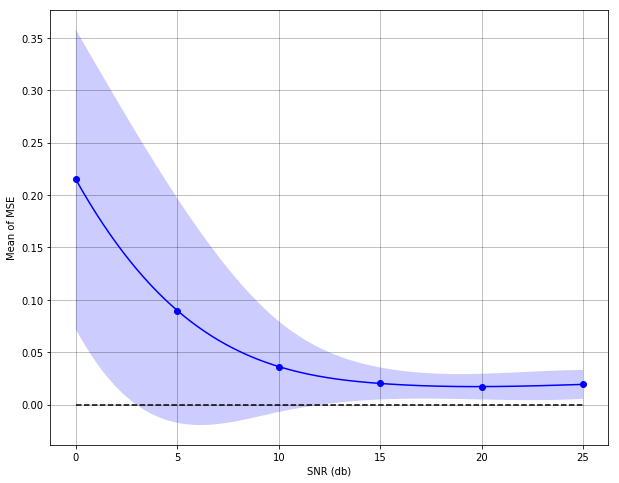

In [122]:
dbs = np.array(dbs)

fig = plt.figure(figsize=(10, 8))

from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(dbs.min(),dbs.max(),300)
spl1 = make_interp_spline(dbs, db_errors, k=3)
spl2 = make_interp_spline(dbs, db_stds, k=3)
power_smooth1 = spl1(xnew)
power_smooth2 = spl2(xnew)

plt.plot(xnew, power_smooth1, 'b-')
plt.plot(dbs, db_errors, 'bo')
plt.plot(dbs, np.zeros(db_num), 'k--')

plt.fill_between(xnew, power_smooth1 - power_smooth2, power_smooth1 + power_smooth2, alpha=0.2,facecolor='b')

plt.xlabel('SNR (db)')
plt.ylabel('Mean of MSE')

plt.grid(color='k', alpha=0.3)
# plt.set_axisabove(True3
# plt.ylim(0.0001, 0.5)
# plt.yscale('log')
plt.show()

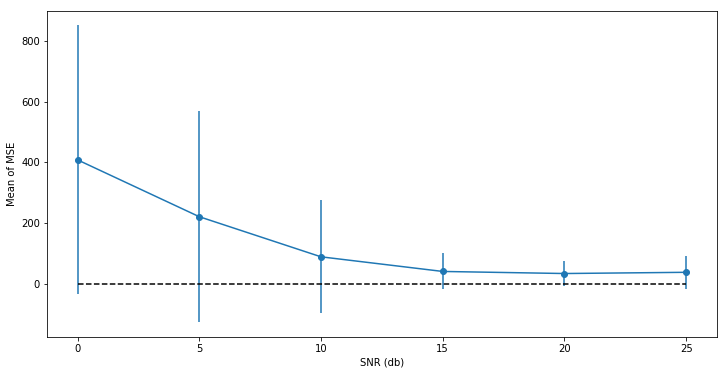

In [68]:
fig = plt.figure(figsize=(12,6))
plt.errorbar(dbs, np.sqrt(db_errors*2)*1024, yerr=np.sqrt(db_stds*2)*1024, fmt='-o')
plt.plot(dbs, np.zeros(db_num), 'k--')
plt.xlabel('SNR (db)')
plt.ylabel('Mean of MSE')
# plt.ylim(0.0001, 0.5)
# plt.yscale('log')
plt.show()

In [ ]:
# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import multi_gpu_model, to_categorical

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle
import h5py

import sys, os, glob
sys.path.append("/home/bryanb/cuckoo-cli/")
import cuckoo_cl

prefix = '/datax/scratch/bbrzycki/training/training2/'



class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, num_labels=1, batch_size=32, dim=(32,1024), n_channels=1, n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.num_labels = num_labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_labels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            filename = prefix + 'data/1sig/train/%s.npy' % ID
            X[i] = np.load(filename).reshape((*self.dim, self.n_channels))
            
            X[i] -= np.mean(X[i])
            X[i] /= np.std(X[i])

            # Store class
            y[i] = self.labels[ID]
#         y = to_categorical(y)

        return X, y

# dimensions of our images.
img_width, img_height = 32, 1024
                                                                 
tsamp = 1.4316557653333333

dir_name = prefix
h5_datasets = prefix + '/data/1sig/1sig.hdf5'
# validation_csv_fn = dir_name + 'train/validation_labels.csv'

##############################################################

total_image_num = 120000
print(total_image_num)
train_num = int(total_image_num * 0.8)
validation_num = total_image_num - train_num

ids = ['%06d' % i for i in range(total_image_num)]
dbs = np.load(prefix + 'data/1sig/dbs.npy')
save_labels = np.load(prefix + 'data/1sig/labels.npy')
labels = {('%06d' % i): save_labels[i] for i in range(total_image_num)}

# Generators
partition = {'train' : [], 'validation' : []}
partition['train'] = ids[:train_num]
partition['validation'] = ids[train_num:]

##############################################################

batch_size = 32

# Parameters
params = {'dim': (32, 1024),
          'batch_size': batch_size,
          'n_channels': 1,
          'num_labels': 2,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

##############################################################

from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Conv2D, Input, Dense
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

def Inception(x, layers=64, activation='relu'):
    tower_0 = Conv2D(layers, (1, 1), padding='same', activation=activation)(x)
    
    tower_1 = Conv2D(layers, (1, 1), padding='same', activation=activation)(x)
    tower_1 = Conv2D(layers, (3, 3), padding='same', activation=activation)(tower_1)

    tower_2 = Conv2D(layers, (1, 1), padding='same', activation=activation)(x)
    tower_2 = Conv2D(layers, (3, 3), padding='same', activation=activation)(tower_2)
    tower_2 = Conv2D(layers, (3, 3), padding='same', activation=activation)(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower_3 = Conv2D(layers, (1, 1), padding='same', activation=activation)(tower_3)

    output = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3], axis=1)
    output = Activation(activation)(output)
    normed = BatchNormalization()(output)
    return normed

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0 = Residual(inputs, 32)
strided0 = Conv2D(32, (3, 3), strides=2)(r0)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)

r2 = Residual(strided2, 64)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
dense1 = Dense(128, activation=activation)(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(2, activation='linear')(drop0)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

# adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='1sig_testing_model.png', show_shapes=True)

#################################################################

model_fn = dir_name + 'models/1sig/testing.h5' 
history_fn = dir_name + 'models/1sig/testing'

epochs = 50

# Train
history = model.fit_generator(generator=training_generator,
                    steps_per_epoch=train_num // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_num // batch_size,
                    callbacks=[keras.callbacks.ModelCheckpoint(model_fn, monitor='loss', verbose=0, save_best_only=True, mode='auto'), 
                               keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-7), 
                               keras.callbacks.EarlyStopping(monitor='loss', patience=10,verbose=0, mode='auto')])

model.save_weights(model_fn)
with open(history_fn, 'wb') as f:
    pickle.dump(history.history, f)


120000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 1024, 1)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 1024, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 32, 1024, 32) 0           input_1[0][0]                    
                                                                 conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 1024, 32) 0           add_1[0][0]                      
___

In [34]:
a = np.array([1,2,3])
b = np.array([2,-1,0])

In [35]:
a-b

array([-1,  3,  3])

In [37]:
np.mean((a - b)**2)

6.333333333333333

In [141]:
A = np.array([[1, 2, 0], [3, 4, 0]])
B = np.array([[5, 6, 0], [7, 8, 0]])

In [142]:
A, B

(array([[1, 2, 0],
        [3, 4, 0]]), array([[5, 6, 0],
        [7, 8, 0]]))

In [143]:
A[:, np.newaxis].shape

(2, 1, 3)

In [153]:
np.stack((A, B))

array([[[1, 2, 0],
        [3, 4, 0]],

       [[5, 6, 0],
        [7, 8, 0]]])

In [157]:
np.transpose(np.stack((A, B)), (1, 2, 0))

array([[[1, 5],
        [2, 6],
        [0, 0]],

       [[3, 7],
        [4, 8],
        [0, 0]]])

In [146]:
A

array([[1, 2, 0],
       [3, 4, 0]])

In [147]:
B

array([[5, 6, 0],
       [7, 8, 0]])

In [158]:
A

array([[1, 2, 0],
       [3, 4, 0]])

In [159]:
A.shape

(2, 3)

In [161]:
np.mean(A, axis=0)

array([2., 3., 0.])